# Chapter 8 - Accounting for seasonality

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import pandas as pd
import itertools as itertls

from tqdm import notebook
from typing import Union

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.seasonal import STL

from sklearn.metrics import mean_squared_error, mean_absolute_error, \
                            mean_absolute_percentage_error


In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  "font.size": 16,
  "grid.alpha": 0.25})

**Function declarations**

In [3]:
def plot_time_series(x, y, xlabel="Time", ylabel="Value", figsize=(10, 4), 
                     use_date_locator=True, title=None, add_mark_at=None):
  fig, ax = plt.subplots(figsize=figsize)

  ax.plot(x, y)

  if use_date_locator:
    formatter = mdates.DateFormatter("%Y")
    # formatter = mdates.DateFormatter("%Y-%b")
    locator = mdates.YearLocator(base=1)
    # locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
    ax.xaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_locator(locator)
  
  if add_mark_at:
    x_loc, cycle_length = add_mark_at
    ax.plot(x[x_loc::cycle_length], y[x_loc::cycle_length], linestyle="None",
      marker='o', markerfacecolor='w', markeredgewidth=2, 
      markeredgecolor="tab:blue")

  ax.grid("on")
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)

  if title is not None:
    ax.set_title(title)

  if use_date_locator:
    for j, label in enumerate(ax.get_xticklabels()):
      label.set_rotation(40)
      label.set_horizontalalignment('right')

  plt.show(fig)


Now we'll add another layer of complexity to the ARIMA model to include  
seasonal patterns in time series, leading us to the SARIMA model.

In this session, we will apply SARIMA model to forecast the total number of  
monthly passengers for an airline.

In [4]:
file_path = "./datasets/air-passengers.csv"
df_passenger = pd.read_csv(file_path, parse_dates=[0])
df_passenger

,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


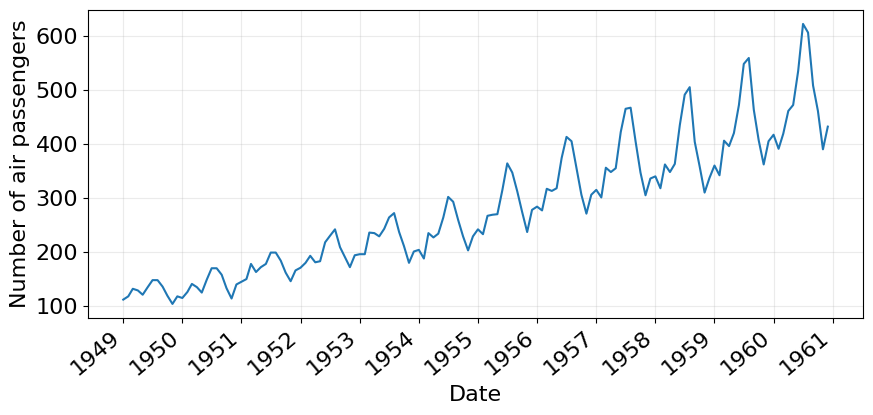

In [5]:
plot_time_series(df_passenger["Month"], df_passenger["Passengers"], 
                 xlabel="Date", ylabel="Number of air passengers")


We can see a clear seasonal pattern in the series. The number of air passengers  
is lower at the beginning and end of the year, and it spikes up during the months  
of June, July, and August. Our objective is to forecast the number of monthly  
air passengers for the one year. It is important for an airline company to forecast  
the number of air passengers so they can better price their tickets and schedule  
flights to meet the demand for a given month.

## 8.1 Examining the $\text{SARIMA}(p,d,q)(P,D,Q)_m$ model

The first parameter that we must define is $m$.  
The paramter $m$ stands for the frequency of the data for given cycle.  
The following tables are the appropriate frequency $m$ depending on the data

| Data collection | Frequency $m$ |  
|-----------------|---------------|  
| Annual          | 1             |  
| Quarterly       | 4             |
| Monthly         | 12            | 
| Weekly          | 52            |

<br>
<table>
  <tr>
    <td rowspan=2> <b>Data collection
    <td colspan=5 style="text-align:center"> <b>Frequency m
  <tr style="text-align:right">
    <td> <b>Minute
    <td> <b>Hour
    <td> <b>Day
    <td> <b>Week
    <td> <b>Year
  <tr style="text-align:right">
    <td style="text-align:left"> Daily
    <td>
    <td>
    <td>
    <td> 7
    <td> 365
  <tr style="text-align:right">
    <td style="text-align:left"> Hourly
    <td>
    <td> 
    <td> 24
    <td> 168
    <td> 8 766
  <tr style="text-align:right">
    <td style="text-align:left"> Every minute
    <td>
    <td> 60
    <td> 1 440
    <td> 10 080
    <td> 525 960
  <tr style="text-align:right">
    <td style="text-align:left"> Every second
    <td> 60
    <td> 3 600
    <td> 86 400
    <td> 604 800
    <td> 31 557 600
</table>

**Seasonal autoregressive integrated moving average (SARIMA) model**  
The _seasonal autoregressive integrated moving average_ (SARIMA) model adds  
seasonal parameters to the $\text{ARIMA}(p,d,q)$ model.  

It is denoted as $\text{SARIMA}(p,d,q)(P,D,Q)_m$ where $P$ is the order of  
the seasonal $\text{AR}(P)$ process, $D$ is the seasonal order of integration,  
$Q$ is the order of the seasonal $\text{MA}(Q)$ process, and $m$ is the frequency,  
or the number of observations per seasonal cycle.  

Note that a $\text{SARIMA}(p,d,q)(0,0,0)_m$ model is equivalent to an 
$\text{ARIMA}(p,d,q)$ model


Let's consider an example where $m = 12$.   
If $P = 2$, this means that we are including two past values of the series at   
a lag that is a multiple of $m$. Therefore, we'll include the values at  
$y_{t-12}$ and $y_{t-24}$.   
Similarly, if $D=1$, this means that a seasonal difference makes the series  
stationary. In this case, a seasonal difference would be expressed as 
$$
y'_t = y_t - y_{t-12}
$$
In a situation where $Q=2$, we'll include past error terms at lags that are  
a multiple of $m$. Therefore, we'll include the errors $\epsilon_{t-12}$  
and $\epsilon_{t-24}$

The following plot shows that in July for each year, we always have the   
highest number of passengers. So it would be important to include those months
in each year when doing forecasting.

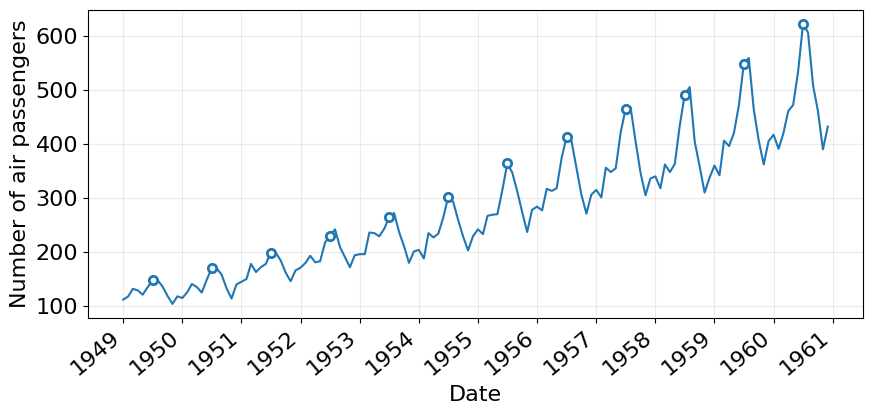

In [6]:
plot_time_series(df_passenger["Month"], df_passenger["Passengers"], 
                 xlabel="Date", ylabel="Number of air passengers", 
                 add_mark_at=[6, 12])

## 8.2 Identifying seasonal patterns in a time series

We can use time series decomposition

**Time series decomposition**  
_Time series decomposition_ is a statistical task that separates the time series  
into its three main components: a trend component, a seasonal component, and  
the residuals.

The trend component represents the long-term change in the time series. This   
component is responsible for time series that increase or decrease over time.  
The seasonal component is the periodic pattern in the time series. It represents   
repeated fluctuations that occurs over a fixed period of time. Finally,   
the residuals, or the noise express any irregularity that cannot be explained  
by the trend or the seaonal component.


In [7]:
advanced_decomposition = STL(df_passenger["Passengers"], period=12).fit()
advanced_decomposition

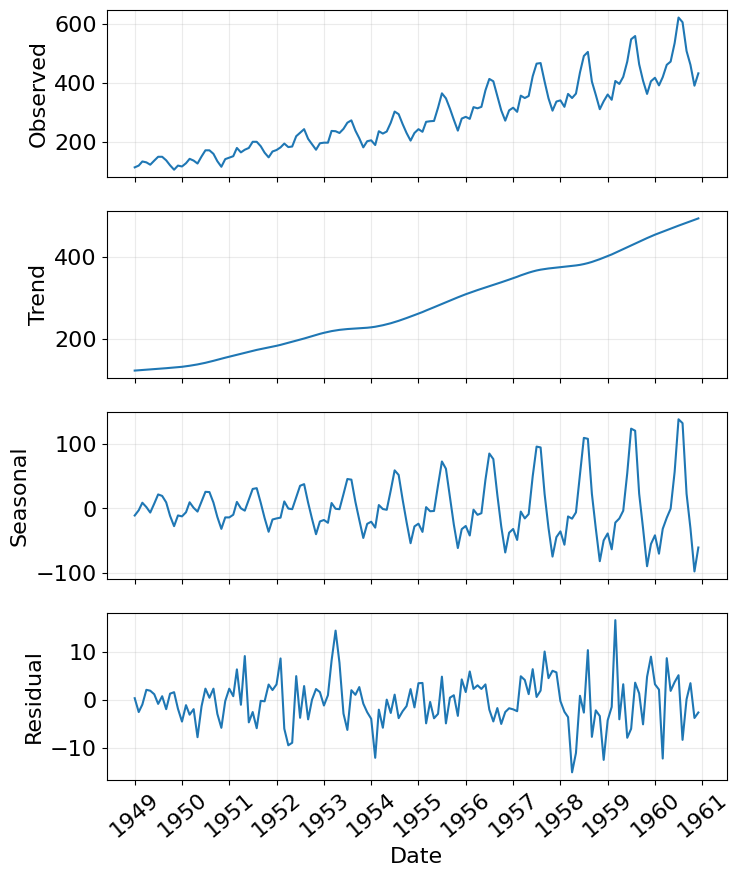

In [8]:
fig, axes = plt.subplots(nrows=4, figsize=(8, 10), sharex=True)

axes[0].plot(df_passenger["Month"], advanced_decomposition.observed)
axes[1].plot(df_passenger["Month"], advanced_decomposition.trend)
axes[2].plot(df_passenger["Month"], advanced_decomposition.seasonal)
axes[3].plot(df_passenger["Month"], advanced_decomposition.resid)

formatter = mdates.DateFormatter("%Y")
locator = mdates.YearLocator(base=1)
axes[3].xaxis.set_major_formatter(formatter)
axes[3].xaxis.set_major_locator(locator)
for label in axes[3].get_xticklabels():
  label.set_rotation(40)

axes[0].set_ylabel("Observed")
axes[1].set_ylabel("Trend")
axes[2].set_ylabel("Seasonal")
axes[3].set_ylabel("Residual")
axes[3].set_xlabel("Date")

for ax in axes:
  ax.grid("on")

plt.show(fig)

In the textbook, the author said there is no statistical test for detecting
seasonality. Fortunately, we found from the following paper:   
(Canova and Hansen, 1995) - _Are seasonal patterns constant over time? A test for seasonal stability_  
and its [implementation in R](https://search.r-project.org/CRAN/refmans/uroot/html/ch-test.html).
We might have to wait for the next release of `statsmodels` if the developers
will implement it or not.

## 8.3 Forecasting the number of monthly air passengers

### 8.3.1 Forecasting with an $\text{ARIMA}(p,d,q)$ model

#### Determine the integrated order $d$

Original time series

In [9]:
ADF_result = adfuller(df_passenger['Passengers'])
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: 0.8153688792060498
p-value: 0.991880243437641


first-order differencing

In [10]:
passenger_first_diff = np.diff(df_passenger["Passengers"], n=1)
ADF_result = adfuller(passenger_first_diff)
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: -2.8292668241700047
p-value: 0.05421329028382478


Second-order differencing

In [11]:
passenger_second_diff = np.diff(passenger_first_diff, n=1)
ADF_result = adfuller(passenger_second_diff)
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")


ADF statistic: -16.384231542468513
p-value: 2.7328918500142026e-29


Since the series was differenced twice to become stationary, $d = 2$.

#### Define possible ranges for $p$, $q$, $P$, and $Q$

In [12]:
p_space = range(0, 13, 1)  # set 0 to 12 to capture seasonal information
q_space = range(0, 13, 1)
P_space = [0]   # set P and Q to 0 because we are working with ARIMA(p,d,q)
Q_space = [0]

d = 2
D = 0   # set D = 0, because we are working with ARIMA(p,d,q)
m = 12

arima_order_list = list(itertls.product(p_space, q_space, P_space, Q_space))
print(f"num. of possible paramters setting: {len(arima_order_list)}")
arima_order_list

num. of possible paramters setting: 169


[(0, 0, 0, 0),
 (0, 1, 0, 0),
 (0, 2, 0, 0),
 (0, 3, 0, 0),
 (0, 4, 0, 0),
 (0, 5, 0, 0),
 (0, 6, 0, 0),
 (0, 7, 0, 0),
 (0, 8, 0, 0),
 (0, 9, 0, 0),
 (0, 10, 0, 0),
 (0, 11, 0, 0),
 (0, 12, 0, 0),
 (1, 0, 0, 0),
 (1, 1, 0, 0),
 (1, 2, 0, 0),
 (1, 3, 0, 0),
 (1, 4, 0, 0),
 (1, 5, 0, 0),
 (1, 6, 0, 0),
 (1, 7, 0, 0),
 (1, 8, 0, 0),
 (1, 9, 0, 0),
 (1, 10, 0, 0),
 (1, 11, 0, 0),
 (1, 12, 0, 0),
 (2, 0, 0, 0),
 (2, 1, 0, 0),
 (2, 2, 0, 0),
 (2, 3, 0, 0),
 (2, 4, 0, 0),
 (2, 5, 0, 0),
 (2, 6, 0, 0),
 (2, 7, 0, 0),
 (2, 8, 0, 0),
 (2, 9, 0, 0),
 (2, 10, 0, 0),
 (2, 11, 0, 0),
 (2, 12, 0, 0),
 (3, 0, 0, 0),
 (3, 1, 0, 0),
 (3, 2, 0, 0),
 (3, 3, 0, 0),
 (3, 4, 0, 0),
 (3, 5, 0, 0),
 (3, 6, 0, 0),
 (3, 7, 0, 0),
 (3, 8, 0, 0),
 (3, 9, 0, 0),
 (3, 10, 0, 0),
 (3, 11, 0, 0),
 (3, 12, 0, 0),
 (4, 0, 0, 0),
 (4, 1, 0, 0),
 (4, 2, 0, 0),
 (4, 3, 0, 0),
 (4, 4, 0, 0),
 (4, 5, 0, 0),
 (4, 6, 0, 0),
 (4, 7, 0, 0),
 (4, 8, 0, 0),
 (4, 9, 0, 0),
 (4, 10, 0, 0),
 (4, 11, 0, 0),
 (4, 12, 0, 0),
 (5, 0, 0,

#### Determine the best ARIMA model

In `SARIMAX()`, we add `seasonal_order=()`

In [13]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, 
                    D: int, m: int,
                    enforce_stationarity: bool=True, 
                    enforce_invertibility: bool=True) -> pd.DataFrame:

  result = []
  # warnings.filterwarnings("error")   # handling warnings as error
  # warnings.resetwarnings()     # to reset warnings

  for order in notebook.tqdm(order_list):
    # print(f"{(order[0], order[1])}")
    try:
      model = SARIMAX(endog, order=(order[0], d, order[1]), 
                      seasonal_order=(order[2], D, order[3], m), 
                      simple_differencing=False, 
                      enforce_invertibility=enforce_invertibility,
                      enforce_stationarity=enforce_stationarity).fit(disp=False)
    except:
      continue

    aic = model.aic
    result.append([order, aic])

  
  result_df = pd.DataFrame(result)
  # print(result_df.columns)
  result_df.columns = ["(p,q,P,Q)", "AIC"]

  # Sort in ascending order, lower AIC is better
  result_df = result_df.sort_values(by="AIC", ascending=True).reset_index(drop=True)

  return result_df


Separate between train and test where the test set is the last 12 months

In [14]:
df_train = df_passenger[:-12]    # 12 months of the last year
df_test = df_passenger[-12:]

print(f"(len(df_train), len(df_test)): {len(df_train), len(df_test)}")

(len(df_train), len(df_test)): (132, 12)


Loop through all possible models

In [15]:
# Computational time: 8 mins 37 secs
# arima_result_df = optimize_SARIMA(df_train["Passengers"], arima_order_list, d,
#                           D, m, enforce_invertibility=True, enforce_stationarity=True)

In [16]:
# arima_result_df.to_csv("./results/ch-08-arima-result.csv", index=False)

In [17]:
reload_arima_result_df = pd.read_csv("./results/ch-08-arima-result.csv")
reload_arima_result_df

,"(p,q,P,Q)",AIC
0,"(10, 12, 0, 0)",64.550735
1,"(11, 3, 0, 0)",1016.842652
2,"(11, 4, 0, 0)",1019.034751
3,"(11, 5, 0, 0)",1020.379289
4,"(11, 1, 0, 0)",1021.025922
...,...,...
164,"(5, 0, 0, 0)",1281.732157
165,"(3, 0, 0, 0)",1300.282335
166,"(2, 0, 0, 0)",1302.913196
167,"(1, 0, 0, 0)",1308.152194


Disply the sorted `DataFrame` in increasing order of AIC

In [18]:
# arima_result_df
reload_arima_result_df

,"(p,q,P,Q)",AIC
0,"(10, 12, 0, 0)",64.550735
1,"(11, 3, 0, 0)",1016.842652
2,"(11, 4, 0, 0)",1019.034751
3,"(11, 5, 0, 0)",1020.379289
4,"(11, 1, 0, 0)",1021.025922
...,...,...
164,"(5, 0, 0, 0)",1281.732157
165,"(3, 0, 0, 0)",1300.282335
166,"(2, 0, 0, 0)",1302.913196
167,"(1, 0, 0, 0)",1308.152194


We select the second model $(p, q) = (11, 3)$ (the model that has the second  
lowest AIC) because if we implement the first model ($(p, q) = (10, 12)$),  
we have a bad result in residual analysis. See `./figures/ch-08-bad-result-arima(10,2,12).png`

In [19]:
best_pqPQ = reload_arima_result_df["(p,q,P,Q)"].iloc[1]
best_arima_p, best_arima_q, _, _ = tuple(map(int, best_pqPQ.strip("()").split(", ")))
print(f"best ARIMA (p,q): {(best_arima_p, best_arima_q)}")

best ARIMA (p,q): (11, 3)


Perform residual analysis

In [20]:
model_arima_best = SARIMAX(df_train["Passengers"], order=(best_arima_p, d, best_arima_q), 
                        simple_differencing=False)
model_arima_best_fit = model_arima_best.fit(disp=False)

/home/henokh/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/henokh/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/henokh/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


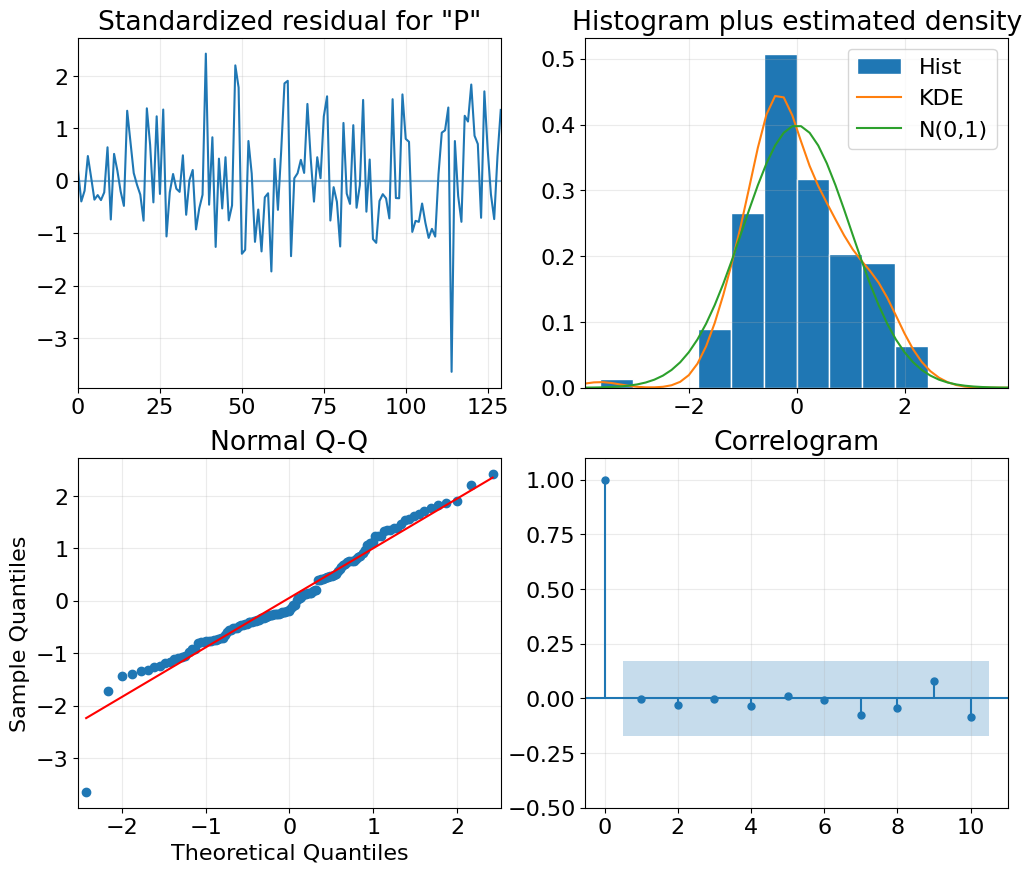

In [21]:
fig = model_arima_best_fit.plot_diagnostics(figsize=(12, 10))

# get all axes
axs = fig.get_axes()
for ax in axs:
  ax.grid("on")

# set y-lim for correlogram plot
axs[3].set_ylim([-0.5, 1.1])
plt.show(fig)


Quantitative test for the residual analysis (Ljung-Box test)

In [22]:
residuals = model_arima_best_fit.resid
ljung_box_test = acorr_ljungbox(residuals, np.arange(1, 11))
ljung_box_test

,lb_stat,lb_pvalue
1,6.539124,0.010553
2,6.667840,0.035653
3,6.943387,0.073724
4,7.736593,0.101718
5,8.377928,0.136601
6,8.669212,0.193054
7,9.493241,0.219155
8,9.731307,0.284393
9,9.741755,0.371793
10,11.546080,0.316583


- The first two $p$-value are smaller than 0.05, so we reject the null hypothesis  
  with a 5% chance of being wrong. Those two lag are correlated
- Starting at lag 3, we have $p$-valus are greater than 0.05, so we do not reject  
  the null hypothesis, concluding that the resiudlas are uncorrelated at lag 3   
  and after that.

Becaue not for all lags our residuals are uncorrelated, we have that the ARIMA   
model is not capturing all the information from the data.

Now we can use our $\text{ARIMA}(11, 2, 3)$ model to forecast all quarters
in the last year.  
For the benchmark, we also compare it with the naive seasonal model.


In [23]:
df_test_pred = df_test.copy()

TRAIN_LEN = len(df_train)
HORIZON = len(df_test)

pred_naive_seasonal = df_train["Passengers"].iloc[-HORIZON:].values
pred_arima = model_arima_best_fit.get_prediction(
  TRAIN_LEN, TRAIN_LEN + HORIZON - 1).predicted_mean

df_test_pred["pred_naive_seasonal"] = pred_naive_seasonal
df_test_pred["pred_arima"] = pred_arima

df_test_pred.head()

,Month,Passengers,pred_naive_seasonal,pred_arima
132,1960-01-01,417,360,422.423451
133,1960-02-01,391,342,410.712068
134,1960-03-01,419,406,461.932587
135,1960-04-01,461,396,457.887529
136,1960-05-01,472,420,481.783456


We will compare later this result with SARIMA

### 8.3.2 Forecasting with an $\text{SARIMA}(p,d,q)(P,D,Q)_m$ model

General modeling procedure for a SARIMA model.

<img src="./figures/identify-nonstationary-general-procedure-sarima.drawio.png" width=600>


#### Determine the seasonal integrated order $D$

In [24]:
ADF_result = adfuller(df_passenger['Passengers'])
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: 0.8153688792060498
p-value: 0.991880243437641


The $p$-value is larger than 0.05. Now we continue to do the first differencing

In [25]:
passenger_first_diff = np.diff(df_passenger["Passengers"], n=1)
ADF_result = adfuller(passenger_first_diff)
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")


ADF statistic: -2.8292668241700047
p-value: 0.05421329028382478


The $p$-value is close enough to $0.05$ but still larger enough. We hold this  
$d$ order and contine with seasonal first differencing to get the order $D$

Seasonal first-order differencing

In [26]:
passenger_first_diff_seasonal = np.diff(passenger_first_diff, n=12)
ADF_result = adfuller(passenger_first_diff_seasonal)
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")


ADF statistic: -17.62486236026156
p-value: 3.823046855601547e-30


Because we have a large and negative ADF statistic and a $p$-value that is  
smaller than $0.05$, we reject the null hypothesis and conclude that our  
transformed series is stationary. We have the combination of $(d, D) = (1, 1)$

#### Define the range of possible values for $p$, $q$, $P$ and $Q$

In [27]:
p_space = range(0, 4, 1)  
q_space = range(0, 4, 1)
P_space = range(0, 4, 1)   
Q_space = range(0, 4, 1)

d = 1
D = 1   # set D = 0, because we are working with ARIMA(p,d,q)
m = 12

sarima_order_list = list(itertls.product(p_space, q_space, P_space, Q_space))
print(f"num. of possible paramters setting: {len(sarima_order_list)}")
sarima_order_list


num. of possible paramters setting: 256


[(0, 0, 0, 0),
 (0, 0, 0, 1),
 (0, 0, 0, 2),
 (0, 0, 0, 3),
 (0, 0, 1, 0),
 (0, 0, 1, 1),
 (0, 0, 1, 2),
 (0, 0, 1, 3),
 (0, 0, 2, 0),
 (0, 0, 2, 1),
 (0, 0, 2, 2),
 (0, 0, 2, 3),
 (0, 0, 3, 0),
 (0, 0, 3, 1),
 (0, 0, 3, 2),
 (0, 0, 3, 3),
 (0, 1, 0, 0),
 (0, 1, 0, 1),
 (0, 1, 0, 2),
 (0, 1, 0, 3),
 (0, 1, 1, 0),
 (0, 1, 1, 1),
 (0, 1, 1, 2),
 (0, 1, 1, 3),
 (0, 1, 2, 0),
 (0, 1, 2, 1),
 (0, 1, 2, 2),
 (0, 1, 2, 3),
 (0, 1, 3, 0),
 (0, 1, 3, 1),
 (0, 1, 3, 2),
 (0, 1, 3, 3),
 (0, 2, 0, 0),
 (0, 2, 0, 1),
 (0, 2, 0, 2),
 (0, 2, 0, 3),
 (0, 2, 1, 0),
 (0, 2, 1, 1),
 (0, 2, 1, 2),
 (0, 2, 1, 3),
 (0, 2, 2, 0),
 (0, 2, 2, 1),
 (0, 2, 2, 2),
 (0, 2, 2, 3),
 (0, 2, 3, 0),
 (0, 2, 3, 1),
 (0, 2, 3, 2),
 (0, 2, 3, 3),
 (0, 3, 0, 0),
 (0, 3, 0, 1),
 (0, 3, 0, 2),
 (0, 3, 0, 3),
 (0, 3, 1, 0),
 (0, 3, 1, 1),
 (0, 3, 1, 2),
 (0, 3, 1, 3),
 (0, 3, 2, 0),
 (0, 3, 2, 1),
 (0, 3, 2, 2),
 (0, 3, 2, 3),
 (0, 3, 3, 0),
 (0, 3, 3, 1),
 (0, 3, 3, 2),
 (0, 3, 3, 3),
 (1, 0, 0, 0),
 (1, 0, 0, 1),
 (1, 0, 0,

#### Determine the best SARIMA model

Separate between train and test where the test set is the last 12 months

In [28]:
df_train = df_passenger[:-12]    # 12 months of the last year
df_test = df_passenger[-12:]

print(f"(len(df_train), len(df_test)): {len(df_train), len(df_test)}")

(len(df_train), len(df_test)): (132, 12)


Loop through all possible models

In [29]:
# Computational time: 30 mins
# sarima_result_df = optimize_SARIMA(df_train["Passengers"], sarima_order_list, d,
#                           D, m, enforce_invertibility=True, enforce_stationarity=True)

In [30]:
# sarima_result_df.to_csv("./results/ch-08-sarima-result.csv", index=False)

In [31]:
reload_sarima_result_df = pd.read_csv("./results/ch-08-sarima-result.csv")
reload_sarima_result_df

,"(p,q,P,Q)",AIC
0,"(2, 1, 1, 2)",892.245047
1,"(2, 1, 1, 3)",894.082348
2,"(1, 0, 1, 2)",894.287272
3,"(2, 1, 2, 3)",894.476601
4,"(0, 1, 1, 2)",894.991248
...,...,...
251,"(0, 0, 2, 0)",906.940147
252,"(3, 2, 0, 3)",907.181875
253,"(0, 0, 3, 2)",907.543943
254,"(0, 0, 3, 0)",908.742583


Disply the sorted `DataFrame` in increasing order of AIC

In [32]:
# sarima_result_df
reload_sarima_result_df

,"(p,q,P,Q)",AIC
0,"(2, 1, 1, 2)",892.245047
1,"(2, 1, 1, 3)",894.082348
2,"(1, 0, 1, 2)",894.287272
3,"(2, 1, 2, 3)",894.476601
4,"(0, 1, 1, 2)",894.991248
...,...,...
251,"(0, 0, 2, 0)",906.940147
252,"(3, 2, 0, 3)",907.181875
253,"(0, 0, 3, 2)",907.543943
254,"(0, 0, 3, 0)",908.742583


In [47]:
best_pqPQ = reload_sarima_result_df["(p,q,P,Q)"].iloc[0]
best_sarima_p, best_sarima_q, best_sarima_P, best_sarima_Q \
  = tuple(map(int, best_pqPQ.strip("()").split(", ")))
print(f"best SARIMA (p,q,P,Q): {(best_sarima_p, best_sarima_q, best_sarima_P, best_sarima_Q)}")

best SARIMA (p,q,P,Q): (2, 1, 1, 2)


Perform residual analysis

In [48]:
model_sarima_best = SARIMAX(df_train["Passengers"], order=(best_sarima_p, d, best_sarima_q), 
                            seasonal_order=(best_sarima_P, D, best_sarima_Q, m),
                            simple_differencing=False)
model_sarima_best_fit = model_sarima_best.fit(disp=False)

/home/henokh/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/henokh/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


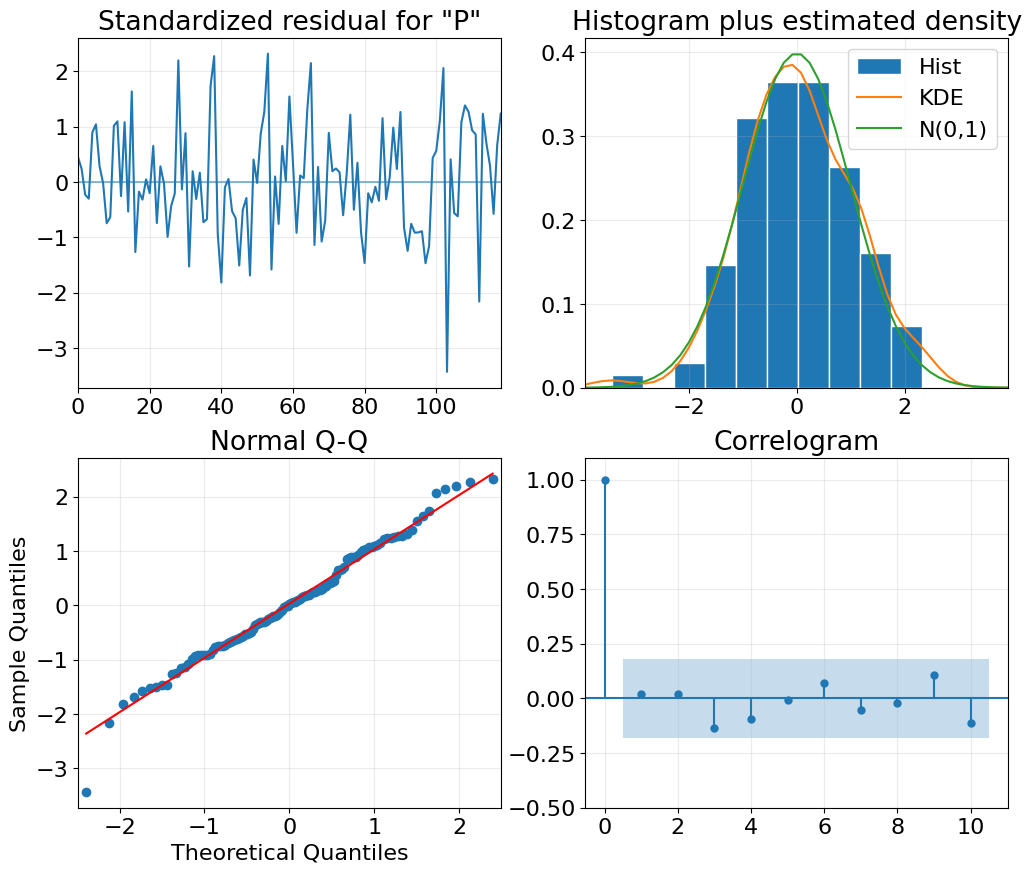

In [49]:
fig = model_sarima_best_fit.plot_diagnostics(figsize=(12, 10))

# get all axes
axs = fig.get_axes()
for ax in axs:
  ax.grid("on")

# set y-lim for correlogram plot
axs[3].set_ylim([-0.5, 1.1])
plt.show(fig)


Quantitative test for the residual analysis (Ljung-Box test)

In [50]:
residuals = model_sarima_best_fit.resid
ljung_box_test = acorr_ljungbox(residuals, np.arange(1, 11))
ljung_box_test

,lb_stat,lb_pvalue
1,0.004324,0.947568
2,0.746951,0.688338
3,1.022840,0.795726
4,1.227835,0.873495
5,1.437620,0.920154
6,1.713606,0.944066
7,2.309311,0.940759
8,2.721393,0.950608
9,2.737798,0.973790
10,4.976175,0.892764


All the returned $p$-values are greater than 0.05. Therefore, we do not   
reject the null hypothesis, and we conclude that the residuals are independent  
and uncorrelated, just like the white noise.

Now we are ready to do forecasting for test data.

In [59]:
pred_sarima = model_sarima_best_fit.get_prediction(
  TRAIN_LEN, TRAIN_LEN + HORIZON - 1).predicted_mean

df_test_pred["pred_sarima"] = pred_sarima

df_test_pred


,Month,Passengers,pred_naive_seasonal,pred_arima,pred_sarima
132,1960-01-01,417,360,422.423451,418.520272
133,1960-02-01,391,342,410.712068,399.562141
134,1960-03-01,419,406,461.932587,461.297180
135,1960-04-01,461,396,457.887529,451.421513
136,1960-05-01,472,420,481.783456,473.718022
137,1960-06-01,535,472,531.225222,538.782968
138,1960-07-01,622,548,606.187559,612.440217
139,1960-08-01,606,559,615.417675,624.605835
140,1960-09-01,508,463,525.453898,520.155384
141,1960-10-01,461,407,467.066240,462.825953


### 8.3.3 Comparing the performance of each forecasting method

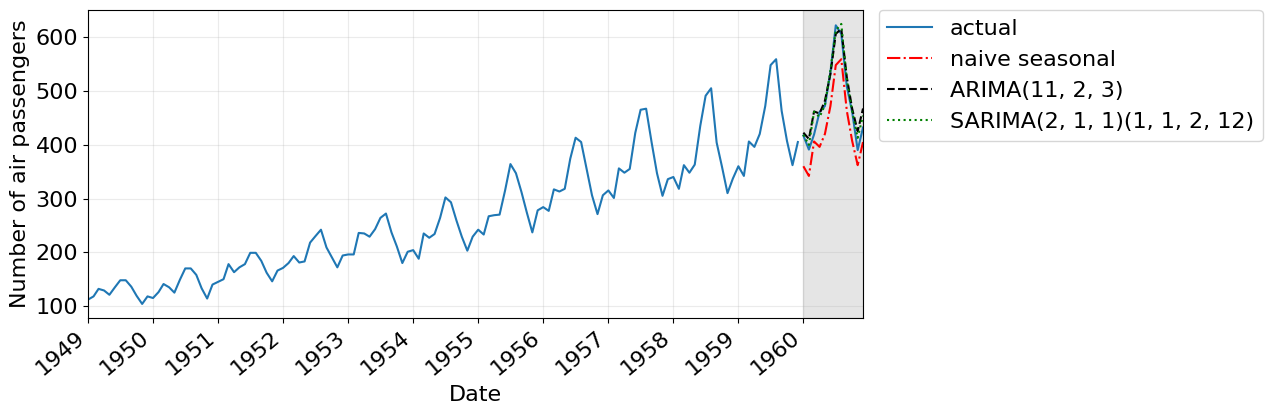

In [60]:
start_idx = 0  # for better visualization
xlim = [df_train["Month"].iloc[start_idx], df_test["Month"].iloc[-1]]

fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(df_train["Month"], df_train["Passengers"])
ax.plot(df_test["Month"], df_test["Passengers"], color="tab:blue", label="actual")

formatter = mdates.DateFormatter("%Y")
# formatter = mdates.DateFormatter("%Y-%b-%d")
locator = mdates.YearLocator(base=1)
# locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
# locator = mdates.DayLocator()
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)
# ax.set_ylim([-0.5, 17])
ax.set_xlim(xlim)
ax.grid("on")
ax.set_xlabel("Date")
ax.set_ylabel("Number of air passengers")

# -- prediction
ax.plot(df_test_pred["Month"], df_test_pred["pred_naive_seasonal"], "r-.", label="naive seasonal")
ax.plot(df_test_pred["Month"], df_test_pred["pred_arima"], "k--", label="ARIMA(11, 2, 3)")
ax.plot(df_test_pred["Month"], df_test_pred["pred_sarima"], "g:", label="SARIMA(2, 1, 1)(1, 1, 2, 12)")

# add forecast area
ax.axvspan(df_test['Month'].iloc[0], df_test['Month'].iloc[-1], 
                color="#808080", alpha=0.2)

for j, label in enumerate(ax.get_xticklabels()):
  label.set_rotation(40)
  label.set_horizontalalignment('right')

# -- add legend in the second row
ax.legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

plt.show(fig)


Zoom in the forecast area

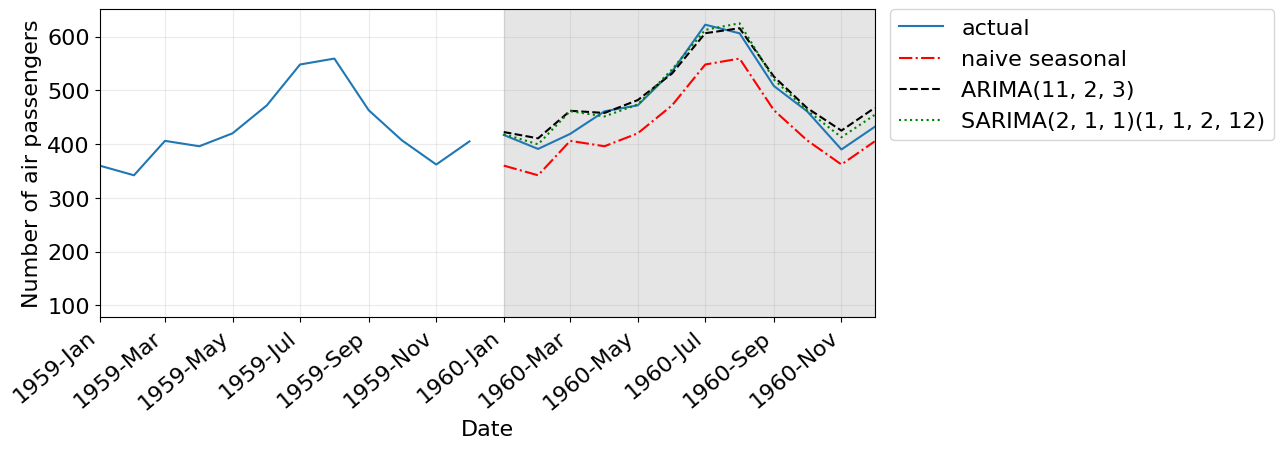

In [61]:
start_idx = 120  # for better visualization
xlim = [df_train["Month"].iloc[start_idx], df_test["Month"].iloc[-1]]

fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(df_train["Month"], df_train["Passengers"])
ax.plot(df_test["Month"], df_test["Passengers"], color="tab:blue", label="actual")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=1)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
# locator = mdates.DayLocator()
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)
# ax.set_ylim([-0.5, 17])
ax.set_xlim(xlim)
ax.grid("on")
ax.set_xlabel("Date")
ax.set_ylabel("Number of air passengers")

# -- prediction
ax.plot(df_test_pred["Month"], df_test_pred["pred_naive_seasonal"], "r-.", label="naive seasonal")
ax.plot(df_test_pred["Month"], df_test_pred["pred_arima"], "k--", label="ARIMA(11, 2, 3)")
ax.plot(df_test_pred["Month"], df_test_pred["pred_sarima"], "g:", label="SARIMA(2, 1, 1)(1, 1, 2, 12)")

# add forecast area
ax.axvspan(df_test['Month'].iloc[0], df_test['Month'].iloc[-1], 
                color="#808080", alpha=0.2)

for j, label in enumerate(ax.get_xticklabels()):
  label.set_rotation(40)
  label.set_horizontalalignment('right')

# -- add legend in the second row
ax.legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

plt.show(fig)


Evaluate the models

In [62]:
mae_naive_seasonal = mean_absolute_error(df_test_pred["Passengers"], df_test_pred["pred_naive_seasonal"])
mae_arima          = mean_absolute_error(df_test_pred["Passengers"], df_test_pred["pred_arima"])
mae_sarima         = mean_absolute_error(df_test_pred["Passengers"], df_test_pred["pred_sarima"])

print(f"MAE naive seasonal: {mae_naive_seasonal}")
print(f"         MAE ARIMA: {mae_arima}")
print(f"        MAE SARIMA: {mae_sarima}")


MAE naive seasonal: 47.833333333333336
         MAE ARIMA: 16.9936241841193
        MAE SARIMA: 12.875299645679553


In [63]:
mape_naive_seasonal = mean_absolute_percentage_error(df_test_pred["Passengers"], df_test_pred["pred_naive_seasonal"]) * 100 
mape_arima          = mean_absolute_percentage_error(df_test_pred["Passengers"], df_test_pred["pred_arima"]) * 100
mape_sarima         = mean_absolute_percentage_error(df_test_pred["Passengers"], df_test_pred["pred_sarima"]) * 100

print(f"MAPE naive seasonal: {mape_naive_seasonal:5.2f}%")
print(f"         MAPE ARIMA: {mape_arima:5.2f}%")
print(f"        MAPE SARIMA: {mape_sarima:5.2f}%")


MAPE naive seasonal:  9.99%
         MAPE ARIMA:  3.84%
        MAPE SARIMA:  2.85%


We see that the SARIMA model is the best-performing method for this situation.  
This makes sense, since our dataset had clear seasonality, and the SARIMA model  
is built to use the seasonal properties of time series to make forecasts.

## 8.4 Next steps

In chapter 4 through 8, we have slowly built a more general and complex model  
starting with the $\text{MA}(q)$ and $\text{AR}(p)$ models, combining them into  
the $\text{ARMA}(p,q)$ model, which led us to the $\text{ARIMA}(p,d,q)$ model,   
and finally to the $\text{SARIMA}(p,d,q)(P,D,Q)_m$ model. These models only   
consider the values of the time series itself. For example, if we wish to model  
country' total spending over time, looking at interest rates or the debt level  
could likely be predictive. How can we include those external variables in  
a model?  

This leads us to the SARIMAX model. Notice that the addition of X which stands  
for _exogonous variables_. This model will combine everything that we have learned  
so far and further expand on it by adding the effect of external variables to  
predict our target.
